In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sci
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from pyXSteam.XSteam import XSteam as xs

In [2]:
# initial conditions
## givens
d = 0.01 # m
qpp = 500e3 # W/m^2
g = 1000 # kg/m^2*s
t_sub = 15 # K

p_atm = 0.101325 # MPa

## calcs
xi = np.pi * d
af = np.pi / 4 * d**2

## fluid
st = xs(xs.UNIT_SYSTEM_BARE) # m/kg/s/K/MPa/W
t_sat = st.tsat_p(p_atm)

t0 = t_sat - t_sub
h0 = st.h_pt(p_atm, t0) * 1000

hf = st.hL_p(p_atm) * 1000
hg = st.hV_p(p_atm) * 1000
hfg = hg - hf

In [3]:
# chi
chi_e0 = (h0 - hf) / hfg

chi = lambda z : qpp * xi * z / af / g / hfg + chi_e0
chi2 = lambda z : qpp * xi * z / af / g / hfg + chi_e0 - 1

x0 = round(sci.optimize.root(chi, 0).x[0], 5)
x1 = round(sci.optimize.root(chi2, 0).x[0], 5)

print(f"----- Chi -----\nchi_(z = 0) = {chi_e0}\nchi_e(z) = 0, z = {x0} m\nchi_e(z) = 1, z = {x1} m")

----- Chi -----
chi_(z = 0) = -0.02797134069261201
chi_e(z) = 0, z = 0.31559 m
chi_e(z) = 1, z = 11.5983 m


In [4]:
# tf
deg = 11

## 1 phase
zs1 = np.linspace(0,x0,1000)
tf1 = []

for z in zs1:
    h = hf + chi(z) * hfg
    tf1.append(st.t_ph(p_atm, h / 1000))

tf_func1 = np.polynomial.Polynomial.fit(zs1, tf1, deg)

## continuous function
def tf_func(z):
    if z <= x0: return tf_func1(z)
    if z <= x1: return t_sat
    if z > x1: raise ValueError(f"{z} is out of the pipe, max z = {x1}")

zs = np.linspace(0, x1, 1000)
tf = []

for z in zs: tf.append(tf_func(z) - 273)

print(f"tf inlet: {tf[0] - 273} *C")
print(f"tf_2phase: {tf_func(x0) - 273} *C")
print(f"tf outlet: {tf[-1] - 273} *C")

tf inlet: -187.8768352914791 *C
tf_2phase: 100.12585950334619 *C
tf outlet: -172.87569999951944 *C


In [5]:
# tw
## constants
mu = 281.66e-6
cp = 4.184e3 # J/kg*K
k = st.tc_pt(p_atm, t0)

pc = st.criticalPressure()
pr = p_atm / pc

dh = 4 * af / xi
Re = g * dh / mu
Pr = cp * mu / k

rho_f = st.rhoL_p(p_atm)
rho_g = st.rhoV_p(p_atm)

mw = 18
h_fluid = k / dh * 0.023 * Re**(0.8) * Pr**(0.4)

## solving
h_l = 0.023 * (k / dh) * Re**(0.8) * Pr**(0.4)
h_pool = 55 * pr**(0.12) * qpp**(2/3) * (-np.log10(pr))**(-0.55) * (mw)**(-0.5)

tw = []
for z in zs:
    t_fluid = tf_func(z)
    
    chi_x = chi(z)
    if chi_x < 0: chi_x = 0

    F = (1 + chi_x * Pr * (rho_f / rho_g - 1))**(0.35)
    S = (1 + 0.055 * F**(0.1) * Re**(0.16))**(-1)

    def tw_func(tw):
        qc1 = F * h_l * (tw - t_fluid)
        qc2 = S * h_pool * (tw - t_sat)

        return (qc1**2 + qc2**2)**(1/2) - qpp

    tw.append(sci.optimize.root(tw_func, 400).x[0] - 273)

In [37]:
print(f"----- Fluid Properties -----\nmu: {mu}\ncp: {cp}\nk: {k}\np_r: {pr}\n")
print(f"----- Dimensionless Groups -----\nRe: {Re}\nPr: {Pr}\n")
print(f"----- Densities -----\nrho_f: {rho_f}\nrho_g: {rho_g}\n")
print(f"----- Heat Transfer Coeffs -----\nh_l: {h_l}\nh_pool: {h_pool}\n")

----- Fluid Properties -----
mu: 0.00028166
cp: 4184.0
k: 0.6701539576736992
p_r: 0.00459233274187079

----- Dimensionless Groups -----
Re: 35503.79890648299
Pr: 1.7584995604454814

----- Densities -----
rho_f: 958.3727293380052
rho_g: 0.5976231155158966

----- Heat Transfer Coeffs -----
h_l: 8436.827865757434
h_pool: 26830.12543946232



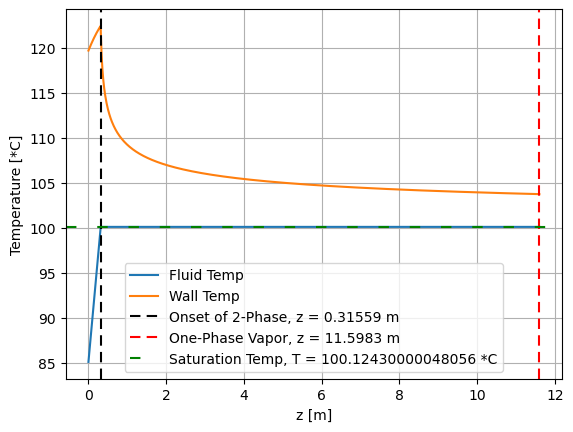

In [16]:
plt.plot(zs, tf, label = "Fluid Temp")
plt.plot(zs, tw, label = "Wall Temp")
plt.axvline(x0, ls=(0,(5,3)), label=f"Onset of 2-Phase, z = {round(x0,5)} m", c='k')
plt.axvline(x1, ls=(0,(5,3)), label=f"One-Phase Vapor, z = {round(x1,5)} m", c='r')
plt.axhline(t_sat - 273, ls=(0,(5,10)), label=f"Saturation Temp, T = {t_sat - 273} *C", c = 'g')

plt.legend(), plt.grid()
plt.xlabel("z [m]"), plt.ylabel("Temperature [*C]")
plt.savefig("temp-plot.png", dpi=600)